Here we will implement the Variational Quantum Eigensolver, which is allows us to determine the eigenvalues of an Hamiltonian and determine the lowest energy of it. IBM has a tutorial on this and I will be using code from there. Link to source (https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver)

In [1]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime.fake_provider import FakeFez
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
backend = FakeFez()


In [3]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

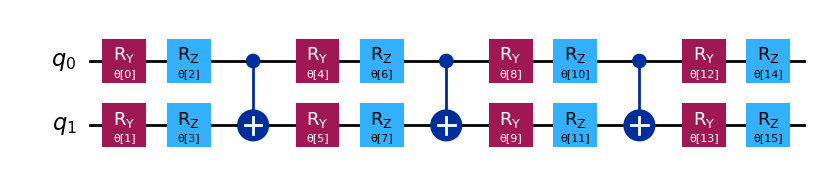

In [4]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [5]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

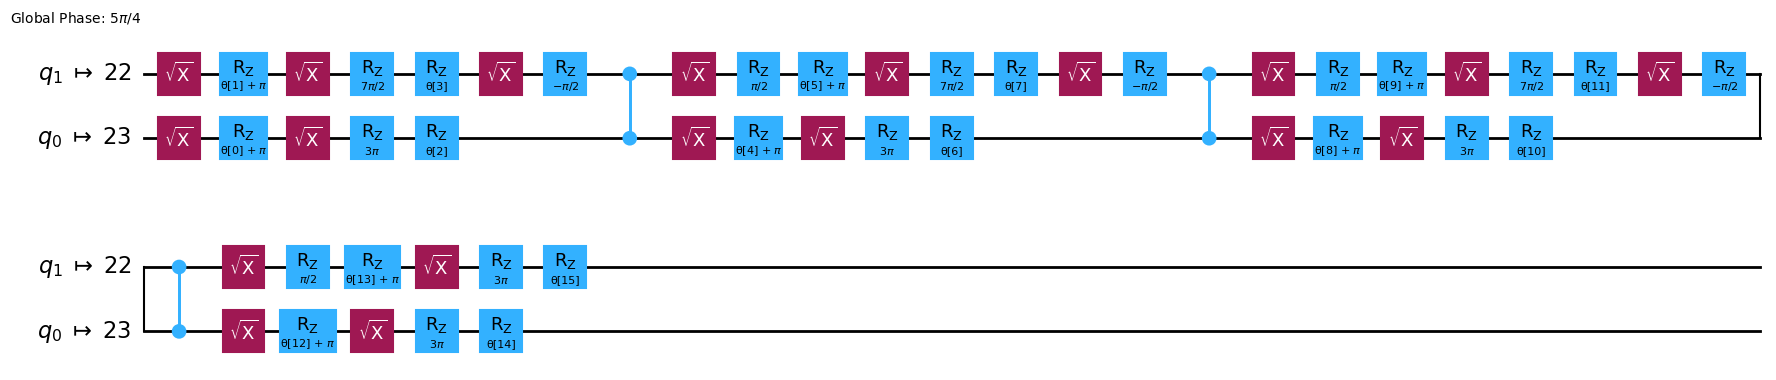

In [6]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [7]:
num_params = ansatz.num_parameters
num_params

16

In [8]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [9]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [10]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [11]:
x0 = 2 * np.pi * np.random.random(num_params)

In [12]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 100

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

Iters. done: 1 [Current cost: 0.28467600000000004]
Iters. done: 2 [Current cost: 0.16959]
Iters. done: 3 [Current cost: 0.25922]
Iters. done: 4 [Current cost: 0.21735000000000002]
Iters. done: 5 [Current cost: 0.24227600000000005]
Iters. done: 6 [Current cost: -0.20446999999999999]
Iters. done: 7 [Current cost: -0.330484]
Iters. done: 8 [Current cost: -0.18913800000000003]
Iters. done: 9 [Current cost: -0.136774]
Iters. done: 10 [Current cost: 0.127328]
Iters. done: 11 [Current cost: -0.21039600000000003]
Iters. done: 12 [Current cost: -0.404386]
Iters. done: 13 [Current cost: -0.255842]
Iters. done: 14 [Current cost: -0.5799000000000001]
Iters. done: 15 [Current cost: -0.3189020000000001]
Iters. done: 16 [Current cost: -0.6690440000000001]
Iters. done: 17 [Current cost: -0.40745400000000004]
Iters. done: 18 [Current cost: -0.29606000000000005]
Iters. done: 19 [Current cost: -0.5696580000000001]
Iters. done: 20 [Current cost: -0.4317659999999999]
Iters. done: 21 [Current cost: -0.56535

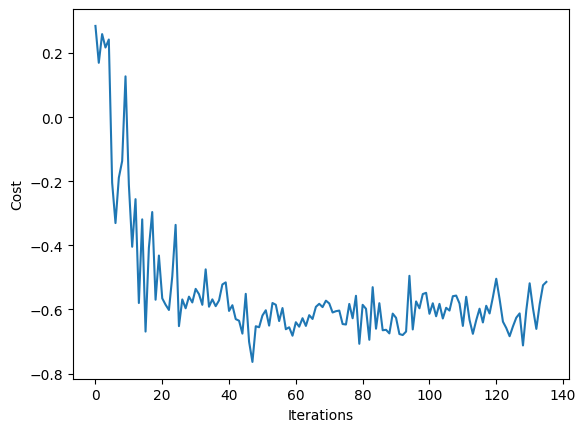

In [15]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [16]:
print(cost_history_dict.get("prev_vector"))

[3.2845898  4.65630613 2.60259215 5.97003473 3.32916615 6.73520232
 2.79690968 2.61562222 1.05901936 5.54184151 6.81117567 3.57138696
 7.06495385 6.09044    6.88969596 1.44349449]


Now while I did just simply copy and past from the Qiskit tutorial, I think I am obligated to explain each step of the process. 

First we begin by importing all of the necessary libraries and imported a fake backend for simulation purposes (I just chose `FakeFez` randomly). Then from there we construct our Hamiltonian $H$, which is simply a linear combination of 2 qubit observables that are mapped to our problem. So if we wanted to compute the minimum energy for a different Hamiltonian, then we can do so. 

Our hamiltonian has observables for 2 qubits, thus by using `hamiltonian.num_qubits` we can extract the number of qubits that the $H$ represents. We can then use the `EfficientSU2` class which is a ansatz (circuit) template that entangles qubits and uses parameterized gates to provide easy access to a group of states in a particular region of the Hilbert Space that $H$ resides in. 

Think of it like this, you have a set of numbers $N$, which are randomly generated between 0 and 1. Your goal is to determine the smallest value in this set, but the set is REALLY BIG. Its unreasonable to think that one can go through the entire set in order to determine the smallest value, so we approximate. Our set is the expectation value of $H$ with different quantum states. The ansatz allows one to sample a portion of the set by allowing one to tweak parameters to reach various states. Then all we need to do is to optimize the expectation value to determine the quantum state that gives it, allowing us to solve various problems which will be addressed soon. For `EfficientSU2`, it is very reliable and simple to run on quantum computers, so that is why we are using it. It also has the added ability to add more parameters to sample larger and larger subsets of the whole Hilbert Space $H$ resides in.

From there, we do our normal things of transpiling the circuit and $H$ to the layout of the backend. This will allow us to run the circuit on the QPU. 

Now we need to create the function that will compute and store the expectation value for any set of parameters. First we define `cost_history_dict` which is the vector (a dictionary here) that contains the interation count, the current set of parameters, and previous expectation values. Once the algorithm is finished, the current set of parameters can be used to find the state that leads the minimum expectation value. Then we define the initial parameters (`x0` here) to start the algorithm. 

Now we run a session within Qiskit which will automatically run the next job when the previous one is done, and allow us to make edits to parameters as needed. We then apply a classical optimizing algorithm, such as COBYLA. However, this optimization problem is a little different compared to other optimization problems. In calculus, you can find the minimum of a function by taking the derivative, computing its zeros, then using either sign analysis or the second derivative test you can determine minima. For multivariable functions, it is a similar process where we find places where the gradient of the function is 0 then using the second derivative test we can determine if the point is a saddle, minima, or maxima. There are other methods as well such as gradient descent, which uses the gradient at a point, $x_n$ to determine values $x_{n+1}$ such that $f(x_n) ≤ f(x_{n+1})$ . 

There is a large issue with these optimization algorithms, which is that they require that we already know the function's formula that we want to minimize, and we can determine its gradient at any point. For computing energy values with a given state, its much more complicated and we cannot simply take the derivative of the following function:

$E(\psi(\theta_i)) = <\psi(\theta_i)|H|\psi(\theta_i)>$

We would need to know EXACTLY what $\psi(\theta_i)$ is, and we cannot due to quantum mechanics. We cannot know the full superposition of $\psi(\theta_i)$ because when we observe $\psi(\theta_i)$ we get a single value. Thus we could approximate the coefficients by looking at the probability distribution, but that would lead to errors that would make the final result unreliable. Furthermore, we construct the superposition using quantum hardware, which means that the second we want to determine its superpostion it would collapse. We can simulate the quantum state using classical computers and determine the coefficients that way, but then the quantum computer is useless and there is no point in running VQE. 

Luckilly there are optimization algorithms that do not rely on gradients, such as COBYLA. The way these work is outside the scope of this notebook, but it is important to note that they exist. 

Finally, once the algorithm has been run, we can construct the approximate (remember that the parameters can only define a subset of all quantum states, not all of them) quantum state. This state then represents the ground state of whatever $H$ represents. For instance, if it was an atom, then we can use this ground state to accurately estimate other properties of the atom such as electron density given that you have the appropriate operator defined already. 

We will now begin to use VQE in order to determine the ground state of the Hydrogen Atom. (WILL BE UPDATED LATER)